# Movie Recommendation System

In [2]:
from collections import Counter
from itertools import combinations
import re

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

import pickle as pk

from jupyterthemes import jtplot
jtplot.style(figsize=(15, 9))

## Data Cleaning

In [3]:
cast_df = pd.read_csv('../data/popular_10000_movies/cast_dataset.csv', index_col='id')
crew_df = pd.read_csv('../data/popular_10000_movies/crew_dataset.csv', index_col='id')
keywords_df = pd.read_csv('../data/popular_10000_movies/keywords_dataframe.csv', index_col='id')
mov_df = pd.read_csv('../data/popular_10000_movies/movies_dataset.csv', index_col='id')

In [4]:
keywords_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [5]:
movies_df = mov_df.merge(cast_df, on='id').merge(crew_df, on ='id').merge(keywords_df, on ='id')
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'])

In [6]:
movies_df.head()

,genre_ids,original_language,overview,popularity,release_date,title,vote_average,vote_count,genres,cast,crew,keywords
id,,,,,,,,,,,,
385687,"[28, 80, 53]",en,Over many missions and against impossible odds...,4654.279,2023-05-17,Fast X,7.3,2093,"Action, Crime, Thriller","[{'cast_id': 12835, 'name': 'Vin Diesel', 'cha...","[{'crew_id': 1302, 'name': 'Susie Figgis', 'de...","[{'id': 9663, 'name': 'sequel'}, {'id': 9748, ..."
697843,"[28, 53]",en,Tasked with extracting a family who is at the ...,2494.010,2023-06-09,Extraction 2,7.7,910,"Action, Thriller","[{'cast_id': 74568, 'name': 'Chris Hemsworth',...","[{'crew_id': 950, 'name': 'Pietro Scalia', 'de...","[{'id': 3070, 'name': 'mercenary'}, {'id': 966..."
603692,"[28, 53, 80]",en,"With the price on his head ever increasing, Jo...",1920.127,2023-03-22,John Wick: Chapter 4,7.9,3344,"Action, Thriller, Crime","[{'cast_id': 6384, 'name': 'Keanu Reeves', 'ch...","[{'crew_id': 3615, 'name': 'Manfred Banach', '...","[{'id': 242, 'name': 'new york city'}, {'id': ..."
569094,"[28, 12, 16, 878]",en,"After reuniting with Gwen Stacy, Brooklyn’s fu...",2013.795,2023-05-31,Spider-Man: Across the Spider-Verse,8.6,1796,"Action, Adventure, Animation, Science Fiction","[{'cast_id': 587506, 'name': 'Shameik Moore', ...","[{'crew_id': 7624, 'name': 'Stan Lee', 'depart...","[{'id': 2858, 'name': 'sacrifice'}, {'id': 328..."
502356,"[16, 10751, 12, 14, 35]",en,"While working underground to fix a water main,...",1539.037,2023-04-05,The Super Mario Bros. Movie,7.8,5165,"Animation, Family, Adventure, Fantasy, Comedy","[{'cast_id': 73457, 'name': 'Chris Pratt', 'ch...","[{'crew_id': 70851, 'name': 'Jack Black', 'dep...","[{'id': 282, 'name': 'video game'}, {'id': 690..."


In [7]:
movies_df.shape

(10652, 12)

In [8]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10652 entries, 385687 to 465109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genre_ids          10652 non-null  object        
 1   original_language  10652 non-null  object        
 2   overview           10649 non-null  object        
 3   popularity         10652 non-null  float64       
 4   release_date       10636 non-null  datetime64[ns]
 5   title              10652 non-null  object        
 6   vote_average       10652 non-null  float64       
 7   vote_count         10652 non-null  int64         
 8   genres             10634 non-null  object        
 9   cast               10652 non-null  object        
 10  crew               10652 non-null  object        
 11  keywords           10652 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 749.0+ KB


In [9]:
movies_df['original_language'].value_counts()

en    10652
Name: original_language, dtype: int64

In [10]:
movies_df.drop('original_language', axis=1, inplace=True)

In [11]:
movies_df.isnull().sum()

genre_ids        0
overview         3
popularity       0
release_date    16
title            0
vote_average     0
vote_count       0
genres          18
cast             0
crew             0
keywords         0
dtype: int64

In [12]:
movies_df.drop(movies_df[movies_df['keywords']=='[]'].index, axis=0, inplace=True)
movies_df.drop(movies_df[movies_df['cast']=='[]'].index, axis=0, inplace=True)
movies_df.drop(movies_df[movies_df['crew']=='[]'].index, axis=0, inplace=True)
movies_df.drop(movies_df[movies_df['vote_average']==0].index, axis=0, inplace=True)
movies_df.drop(movies_df[movies_df['vote_count']<100].index, axis=0, inplace=True)
movies_df.dropna(axis=0, inplace=True)

In [13]:
movies_df.isnull().sum()

genre_ids       0
overview        0
popularity      0
release_date    0
title           0
vote_average    0
vote_count      0
genres          0
cast            0
crew            0
keywords        0
dtype: int64

In [14]:
movies_df[movies_df.duplicated()].shape

(515, 11)

In [15]:
movies_df.drop_duplicates(inplace=True)

In [16]:
movies_df[movies_df.duplicated()].shape

(0, 11)

## EDA

In [52]:
movies_df.groupby('genres').mean().sort_values(['vote_average'], ascending=False).head(10)

,popularity,vote_average,vote_count
genres,,,
"Fantasy, Drama, Crime",69.123,8.5,15537.0
"Drama, Thriller, Comedy",73.566,8.4,26647.0
"TV Movie, Animation, Science Fiction, Action, Adventure, Comedy, Drama, Fantasy, Music",24.249,8.3,754.0
"Family, Animation, Drama",97.326,8.3,16649.0
"Animation, Family, Fantasy, Adventure, Comedy",502.086,8.3,5832.0
"Horror, Music",12.705,8.2,581.0
"Family, Animation, Music",15.704,8.2,143.0
"Family, Animation, Fantasy, Music, Comedy, Adventure",106.932,8.2,17338.0
"Animation, Fantasy, Drama, Music",89.246,8.2,2327.0


In [53]:
movies_df.groupby('genres').mean().sort_values(['vote_average'], ascending=True).head(10)

,popularity,vote_average,vote_count
genres,,,
"Action, Adventure, Fantasy, Science Fiction, Thriller",33.077,2.9,1867.0
"Science Fiction, Horror, Action, Thriller",13.295,2.9,117.0
"Fantasy, Science Fiction, Family, TV Movie",15.379,3.3,408.0
"Horror, Action, Comedy, Science Fiction, Adventure",11.146,3.9,1436.0
"Science Fiction, Comedy, Family",11.359,4.0,321.0
"Adventure, Thriller, Horror",18.743,4.1,885.0
"Crime, Fantasy, Horror, Thriller",16.582,4.2,3696.0
"Horror, Comedy, Mystery, Thriller",16.356,4.3,1168.0
"Mystery, Adventure, Comedy, Crime",15.003,4.3,741.0


In [54]:
movies_df.groupby('genres').count().sort_values(['vote_average'], ascending=False).head(10)

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,cast,crew,keywords
genres,,,,,,,,,,
Drama,405,405,405,405,405,405,405,405,405,405
Comedy,346,346,346,346,346,346,346,346,346,346
"Comedy, Romance",222,222,222,222,222,222,222,222,222,222
"Drama, Romance",214,214,214,214,214,214,214,214,214,214
"Horror, Thriller",170,170,170,170,170,170,170,170,170,170
"Comedy, Drama",169,169,169,169,169,169,169,169,169,169
Horror,140,140,140,140,140,140,140,140,140,140
"Comedy, Drama, Romance",137,137,137,137,137,137,137,137,137,137
"Drama, History",100,100,100,100,100,100,100,100,100,100


In [55]:
movies_df.groupby('genres').count().sort_values(['vote_average'], ascending=False).tail(10)

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,cast,crew,keywords
genres,,,,,,,,,,
"Adventure, Drama, Science Fiction, Fantasy",1,1,1,1,1,1,1,1,1,1
"Adventure, Family, Action, Fantasy",1,1,1,1,1,1,1,1,1,1
"Drama, Mystery, Western",1,1,1,1,1,1,1,1,1,1
"Drama, Mystery, Thriller, TV Movie",1,1,1,1,1,1,1,1,1,1
"Drama, Mystery, Thriller, Romance",1,1,1,1,1,1,1,1,1,1
"Drama, Mystery, Thriller, Horror",1,1,1,1,1,1,1,1,1,1
"Drama, Mystery, Thriller, History",1,1,1,1,1,1,1,1,1,1
"Drama, Mystery, Thriller, Fantasy",1,1,1,1,1,1,1,1,1,1
"Adventure, Drama, Thriller, History",1,1,1,1,1,1,1,1,1,1


In [56]:
movies_df[movies_df['vote_count']>100].sort_values(['vote_average'], ascending=False).head(10)

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,genres,cast,crew,keywords
id,,,,,,,,,,,
238,"[18, 80]","Spanning the years 1945 to 1955, a chronicle o...",120.966,1972-03-14,The Godfather,8.7,18141,"Drama, Crime","[{'cast_id': 3084, 'name': 'Marlon Brando', 'c...","[{'crew_id': 154, 'name': 'Walter Murch', 'dep...","[{'id': 131, 'name': 'italy'}, {'id': 697, 'na..."
373558,"[10402, 99]","Filmed in front of 76,000 fans at the ANZ Stad...",15.562,2015-12-20,Taylor Swift: The 1989 World Tour - Live,8.7,119,"Music, Documentary","[{'cast_id': 212208, 'name': 'Taylor Swift', '...","[{'crew_id': 71329, 'name': 'Jonas Åkerlund', ...","[{'id': 1740, 'name': 'pop culture'}, {'id': 2..."
278,"[18, 80]",Framed in the 1940s for the double murder of h...,107.982,1994-09-23,The Shawshank Redemption,8.7,24021,"Drama, Crime","[{'cast_id': 504, 'name': 'Tim Robbins', 'char...","[{'crew_id': 153, 'name': 'Thomas Newman', 'de...","[{'id': 378, 'name': 'prison'}, {'id': 417, 'n..."
569094,"[28, 12, 16, 878]","After reuniting with Gwen Stacy, Brooklyn’s fu...",2013.795,2023-05-31,Spider-Man: Across the Spider-Verse,8.6,1796,"Action, Adventure, Animation, Science Fiction","[{'cast_id': 587506, 'name': 'Shameik Moore', ...","[{'crew_id': 7624, 'name': 'Stan Lee', 'depart...","[{'id': 2858, 'name': 'sacrifice'}, {'id': 328..."
240,"[18, 80]",In the continuing saga of the Corleone crime f...,68.191,1974-12-20,The Godfather Part II,8.6,10949,"Drama, Crime","[{'cast_id': 1158, 'name': 'Al Pacino', 'chara...","[{'crew_id': 154, 'name': 'Walter Murch', 'dep...","[{'id': 131, 'name': 'italy'}, {'id': 700, 'na..."
424,"[18, 36, 10752]",The true story of how businessman Oskar Schind...,60.506,1993-12-15,Schindler's List,8.6,14198,"Drama, History, War","[{'cast_id': 3896, 'name': 'Liam Neeson', 'cha...","[{'crew_id': 491, 'name': 'John Williams', 'de...","[{'id': 818, 'name': 'based on novel or book'}..."
76115,"[10402, 18, 10749]","A disfigured musical genius, hidden away in th...",13.290,2011-09-27,The Phantom of the Opera at the Royal Albert Hall,8.5,143,"Music, Drama, Romance","[{'cast_id': 145115, 'name': 'Ramin Karimloo',...","[{'crew_id': 14474, 'name': 'Gaston Leroux', '...","[{'id': 4344, 'name': 'musical'}]"
497,"[14, 18, 80]",A supernatural tale set on death row in a Sout...,69.123,1999-12-10,The Green Mile,8.5,15537,"Fantasy, Drama, Crime","[{'cast_id': 31, 'name': 'Tom Hanks', 'charact...","[{'crew_id': 153, 'name': 'Thomas Newman', 'de...","[{'id': 531, 'name': 'southern usa'}, {'id': 7..."
770156,"[10751, 18]",Second chances start when a hardened criminal ...,21.416,2020-10-19,Lucy Shimmers And The Prince Of Peace,8.5,131,"Family, Drama","[{'cast_id': 2643437, 'name': 'Scarlett Diamon...","[{'crew_id': 222497, 'name': 'Rob Diamond', 'd...","[{'id': 3071, 'name': 'prince'}, {'id': 6057, ..."


In [57]:
movies_df[movies_df['vote_count']>100].sort_values(['vote_average'], ascending=True).head(10)

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,genres,cast,crew,keywords
id,,,,,,,,,,,
19157,[35],A struggling young comedian takes a menial job...,11.868,1989-05-11,Going Overboard,2.3,112,Comedy,"[{'cast_id': 19292, 'name': 'Adam Sandler', 'c...","[{'crew_id': 19292, 'name': 'Adam Sandler', 'd...","[{'id': 407, 'name': 'dictator'}, {'id': 2398,..."
10838,"[27, 878]","In the year 3000, the deep space salvage ship ...",11.360,2004-08-09,Dracula 3000,2.7,114,"Horror, Science Fiction","[{'cast_id': 27763, 'name': 'Casper Van Dien',...","[{'crew_id': 15303, 'name': 'Frank Hübner', 'd...","[{'id': 1826, 'name': 'space marine'}, {'id': ..."
14164,"[28, 12, 14, 878, 53]","On his 18th birthday, Goku receives a mystical...",33.077,2009-03-12,Dragonball Evolution,2.9,1867,"Action, Adventure, Fantasy, Science Fiction, T...","[{'cast_id': 503, 'name': 'Justin Chatwin', 'c...","[{'crew_id': 561, 'name': 'John Papsidera', 'd...","[{'id': 3436, 'name': 'karate'}, {'id': 9715, ..."
11525,"[878, 27, 28, 53]",Jobe is resuscitated by Jonathan Walker. He wa...,13.295,1996-01-12,Lawnmower Man 2: Beyond Cyberspace,2.9,117,"Science Fiction, Horror, Action, Thriller","[{'cast_id': 29459, 'name': 'Patrick Bergin', ...","[{'crew_id': 582, 'name': 'Sheri Galloway', 'd...","[{'id': 1576, 'name': 'technology'}, {'id': 21..."
11059,"[27, 28, 53]","Set on an island off the coast, a techno rave ...",11.457,2003-04-11,House of the Dead,3.2,339,"Horror, Action, Thriller","[{'cast_id': 51937, 'name': 'Jonathan Cherry',...","[{'crew_id': 22455, 'name': 'Dan Sales', 'depa...","[{'id': 2041, 'name': 'island'}, {'id': 3221, ..."
5491,"[28, 12, 35, 878]","In the year 3000, man is no match for the Psyc...",12.444,2000-05-12,Battlefield Earth,3.2,725,"Action, Adventure, Comedy, Science Fiction","[{'cast_id': 8891, 'name': 'John Travolta', 'c...","[{'crew_id': 1263, 'name': 'Lynn Stalmaster', ...","[{'id': 818, 'name': 'based on novel or book'}..."
12142,"[28, 14, 27]",Edward Carnby is a private investigator specia...,13.641,2005-01-28,Alone in the Dark,3.3,527,"Action, Fantasy, Horror","[{'cast_id': 2224, 'name': 'Christian Slater',...","[{'crew_id': 21251, 'name': 'Robert Lee', 'dep...","[{'id': 703, 'name': 'detective'}, {'id': 1299..."
74849,"[14, 878, 10751, 10770]",Luke Skywalker and Han Solo battle evil Imperi...,15.379,1978-12-01,The Star Wars Holiday Special,3.3,408,"Fantasy, Science Fiction, Family, TV Movie","[{'cast_id': 2, 'name': 'Mark Hamill', 'charac...","[{'crew_id': 1, 'name': 'George Lucas', 'depar...","[{'id': 65, 'name': 'holiday'}, {'id': 3741, '..."
135812,[27],When Englishman Jonathan Harker visits the exo...,12.126,2012-11-09,Dracula 3D,3.3,192,Horror,"[{'cast_id': 3491, 'name': 'Thomas Kretschmann...","[{'crew_id': 1544, 'name': 'Bram Stoker', 'dep...","[{'id': 3133, 'name': 'vampire'}, {'id': 15032..."


In [58]:
movies_df.sort_values(['popularity'], ascending=False).head(10)

,genre_ids,overview,popularity,release_date,title,vote_average,vote_count,genres,cast,crew,keywords
id,,,,,,,,,,,
385687,"[28, 80, 53]",Over many missions and against impossible odds...,4654.279,2023-05-17,Fast X,7.3,2093,"Action, Crime, Thriller","[{'cast_id': 12835, 'name': 'Vin Diesel', 'cha...","[{'crew_id': 1302, 'name': 'Susie Figgis', 'de...","[{'id': 9663, 'name': 'sequel'}, {'id': 9748, ..."
697843,"[28, 53]",Tasked with extracting a family who is at the ...,2494.010,2023-06-09,Extraction 2,7.7,910,"Action, Thriller","[{'cast_id': 74568, 'name': 'Chris Hemsworth',...","[{'crew_id': 950, 'name': 'Pietro Scalia', 'de...","[{'id': 3070, 'name': 'mercenary'}, {'id': 966..."
569094,"[28, 12, 16, 878]","After reuniting with Gwen Stacy, Brooklyn’s fu...",2013.795,2023-05-31,Spider-Man: Across the Spider-Verse,8.6,1796,"Action, Adventure, Animation, Science Fiction","[{'cast_id': 587506, 'name': 'Shameik Moore', ...","[{'crew_id': 7624, 'name': 'Stan Lee', 'depart...","[{'id': 2858, 'name': 'sacrifice'}, {'id': 328..."
603692,"[28, 53, 80]","With the price on his head ever increasing, Jo...",1920.127,2023-03-22,John Wick: Chapter 4,7.9,3344,"Action, Thriller, Crime","[{'cast_id': 6384, 'name': 'Keanu Reeves', 'ch...","[{'crew_id': 3615, 'name': 'Manfred Banach', '...","[{'id': 242, 'name': 'new york city'}, {'id': ..."
502356,"[16, 10751, 12, 14, 35]","While working underground to fix a water main,...",1539.037,2023-04-05,The Super Mario Bros. Movie,7.8,5165,"Animation, Family, Adventure, Fantasy, Comedy","[{'cast_id': 73457, 'name': 'Chris Pratt', 'ch...","[{'crew_id': 70851, 'name': 'Jack Black', 'dep...","[{'id': 282, 'name': 'video game'}, {'id': 690..."
667538,"[28, 12, 878]",When a new threat capable of destroying the en...,1423.735,2023-06-06,Transformers: Rise of the Beasts,7.1,469,"Action, Adventure, Science Fiction","[{'cast_id': 1560244, 'name': 'Anthony Ramos',...","[{'crew_id': 488, 'name': 'Steven Spielberg', ...","[{'id': 5967, 'name': 'peru'}, {'id': 9951, 'n..."
976573,"[16, 35, 10751, 14, 10749]","In a city where fire, water, land and air resi...",1224.270,2023-06-14,Elemental,7.4,200,"Animation, Comedy, Family, Fantasy, Romance","[{'cast_id': 1087262, 'name': 'Leah Lewis', 'c...","[{'crew_id': 153, 'name': 'Thomas Newman', 'de...","[{'id': 657, 'name': 'fire'}, {'id': 10159, 'n..."
298618,"[878, 28, 12]",When his attempt to save his family inadverten...,965.786,2023-06-13,The Flash,6.7,639,"Science Fiction, Action, Adventure","[{'cast_id': 132157, 'name': 'Ezra Miller', 'c...","[{'crew_id': 2293, 'name': 'Frank Miller', 'de...","[{'id': 1308, 'name': 'secret identity'}, {'id..."
447365,"[28, 878, 12]","Peter Quill, still reeling from the loss of Ga...",960.044,2023-05-03,Guardians of the Galaxy Vol. 3,8.0,2111,"Action, Science Fiction, Adventure","[{'cast_id': 73457, 'name': 'Chris Pratt', 'ch...","[{'crew_id': 960, 'name': 'John Murphy', 'depa...","[{'id': 1701, 'name': 'hero'}, {'id': 9663, 'n..."


### Visualization

Text(0.5, 1.0, 'TOP-10 Most popular movies by vote_average')

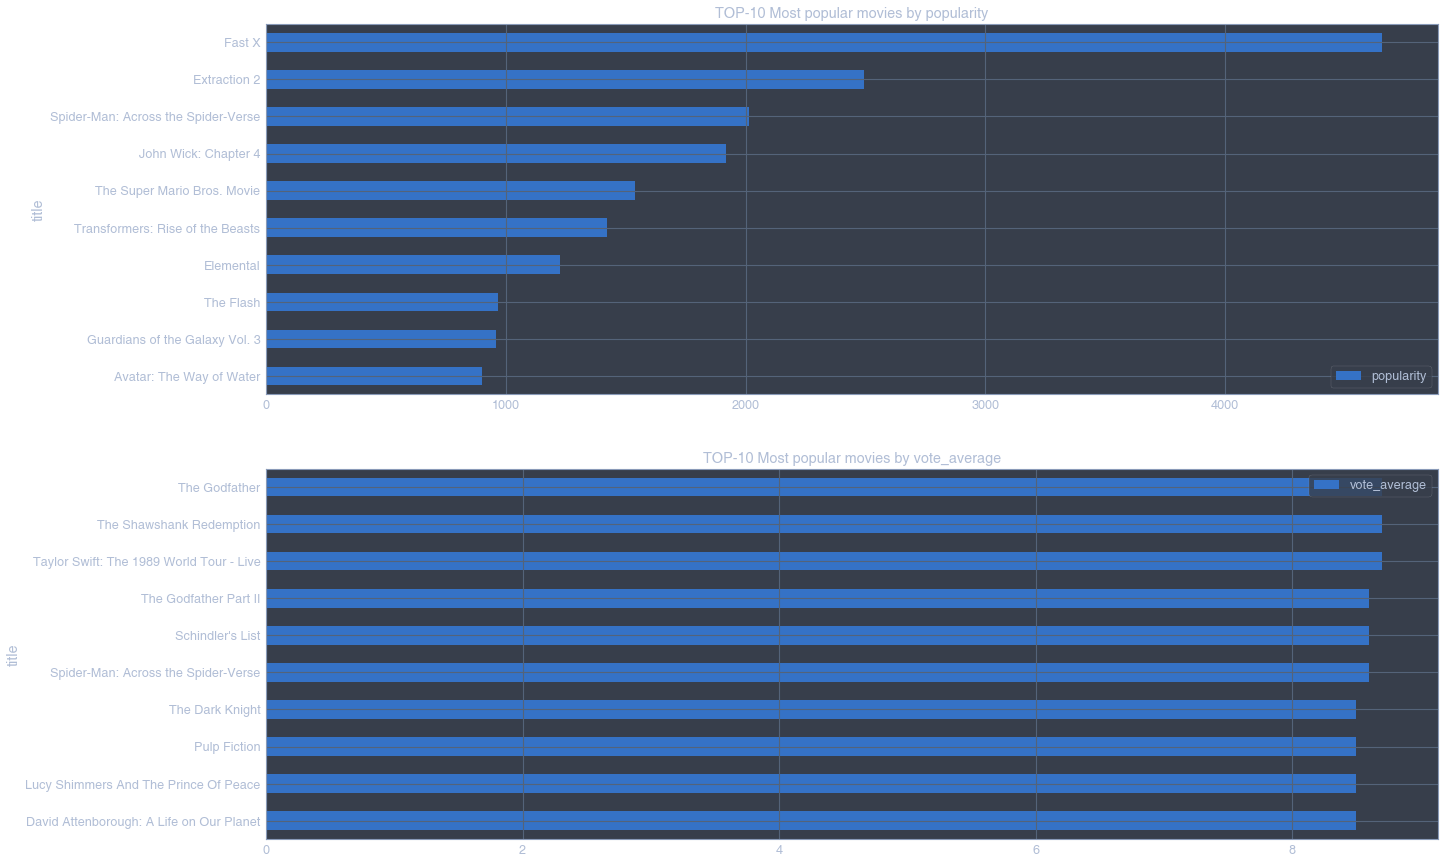

In [64]:
movies_by_popularity = movies_df.sort_values(['popularity'],
                                             ascending=False).head(10)[['title',
                                                                        'popularity']].reset_index(drop=True)
movies_by_popularity.set_index('title', inplace=True)

movies_by_vote_average = movies_df.sort_values(['vote_average'],
                                               ascending=False).head(10)[['title',
                                                                          'vote_average']].reset_index(drop=True)
movies_by_vote_average.set_index('title', inplace=True)


fig, ax = plt.subplots(2, 1, figsize=(21, 15))

movies_by_popularity.plot(kind='barh', ax=ax[0]).invert_yaxis()
ax[0].set_title('TOP-10 Most popular movies by popularity')

movies_by_vote_average.plot(kind='barh', ax=ax[1]).invert_yaxis()
ax[1].set_title('TOP-10 Most popular movies by vote_average')

Text(0, 0.5, 'Vote Count')

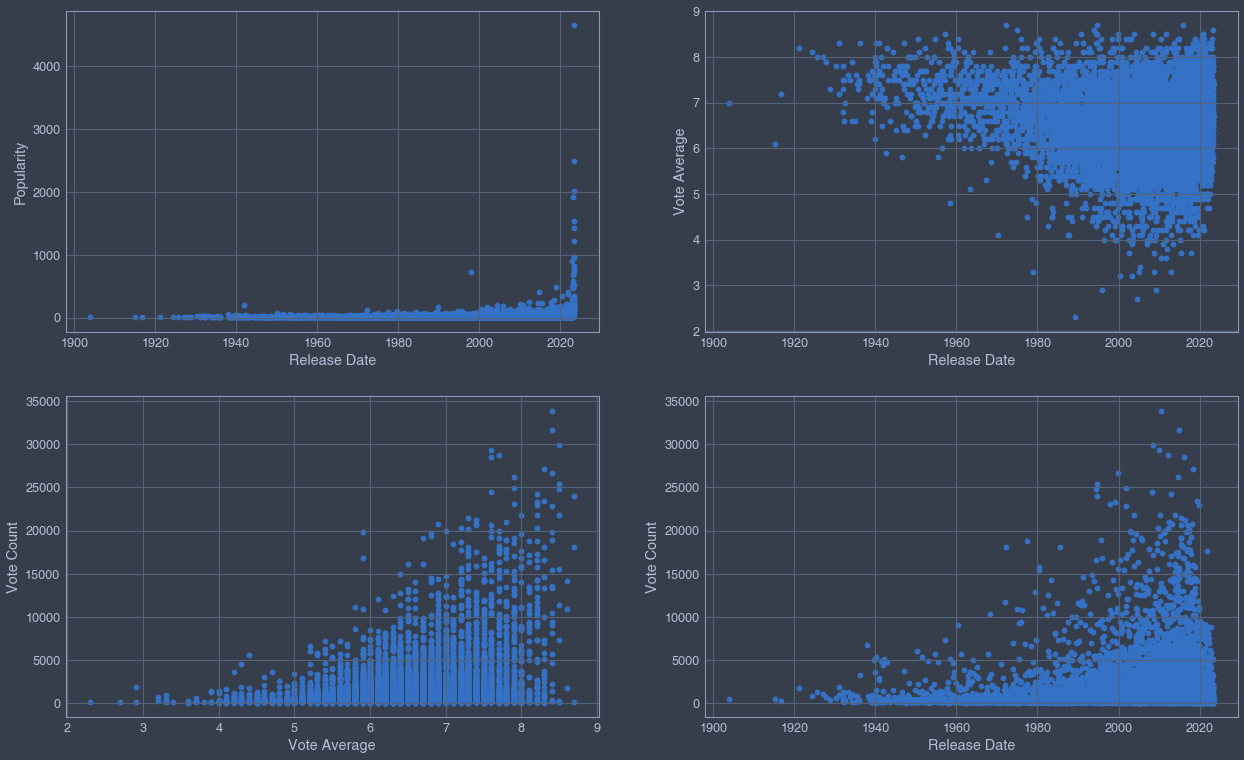

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(21, 13))

axs[0, 0].scatter(movies_df['release_date'], movies_df['popularity'])
axs[0, 0].set_xlabel('Release Date')
axs[0, 0].set_ylabel('Popularity')

axs[0, 1].scatter(movies_df['release_date'], movies_df['vote_average'])
axs[0, 1].set_xlabel('Release Date')
axs[0, 1].set_ylabel('Vote Average')

axs[1, 0].scatter(movies_df['vote_average'], movies_df['vote_count'])
axs[1, 0].set_xlabel('Vote Average')
axs[1, 0].set_ylabel('Vote Count')

axs[1, 1].scatter(movies_df['release_date'], movies_df['vote_count'])
axs[1, 1].set_xlabel('Release Date')
axs[1, 1].set_ylabel('Vote Count')